


**Imaging Data Description**

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes, and were acquired with different clinical protocols and various scanners from multiple (n=19) institutions, mentioned as data contributors here.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.


### <a id='toc1_3_3_'></a>[U-Net Model](#toc0_)

**U-Net** is a fully convolutional neural network originally designed for semantic image segmentation of biomedical images. This network features a distinctive encoder-decoder structure, making it exceptionally effective for detailed and precise image analysis tasks in the medical field. Since its inception, U-Net has been widely recognized for its robust performance in segmenting complex anatomical structures in medical scans, such as MRIs and CT images.

The architecture of U-Net is particularly notable for its ability to capture contextual information at various scales, which is crucial for accurate segmentation. The encoder part of the network progressively reduces the spatial dimension of the image, capturing high-level semantic information. Conversely, the decoder part gradually recovers object details and spatial dimensions, ensuring precise localization.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Kk-yKGkvRtkNzLkZdP3Pag/unet.png" width="70%" alt="indexing"/>

**Reference:**
1. Original Paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

# **DataLoader**

In [1]:
import os
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm


In [2]:

class BraTSSliceDataset(Dataset):
    def __init__(self, root_dir, patient_ids, slice_indices=None, augment=False):
        self.root_dir = root_dir
        self.ids = patient_ids
        self.augment = augment
        self.modalities = ['flair', 't1', 't1ce', 't2']

        self.index_map = []
        for pid in self.ids:
            seg_path = os.path.join(root_dir, pid, f'BraTS20_Training_{pid}_seg.nii')
            depth = nib.load(seg_path).shape[-1]
            slices = slice_indices.get(pid, list(range(depth))) if slice_indices else list(range(depth))
            for z in slices:
                self.index_map.append((pid, z))

        # Compose transforms
        tfms = [T.ToTensor()]
        if augment:
            tfms += [
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                # add T.RandomRotation(15) or albumentations here if you like
            ]
        self.transform = T.Compose(tfms)

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        pid, z = self.index_map[idx]
        imgs = []
        for mod in self.modalities:
            arr = nib.load(
                os.path.join(self.root_dir, pid,
                             f'BraTS20_Training_{pid}_{mod}.nii')
            ).get_fdata()
            slice_img = arr[:, :, z]
            slice_img = (slice_img - slice_img.mean()) / (slice_img.std() + 1e-5)
            imgs.append(slice_img)

        x = np.stack(imgs, axis=-1)          
        mask_arr = nib.load(
            os.path.join(self.root_dir, pid,
                         f'BraTS20_Training_{pid}_seg.nii')
        ).get_fdata()[:, :, z]
        mask = (mask_arr > 0).astype(np.float32)

        # pack and transform
        stacked = np.concatenate([x, mask[..., None]], axis=-1) 
        stacked = self.transform(stacked)                 
        stacked = stacked.float()                               

        return {
            'image': stacked[:4], 
            'mask':  stacked[4] 
        }


Train slices: 283, Train batches: 36
Val   slices: 71,   Val   batches: 9


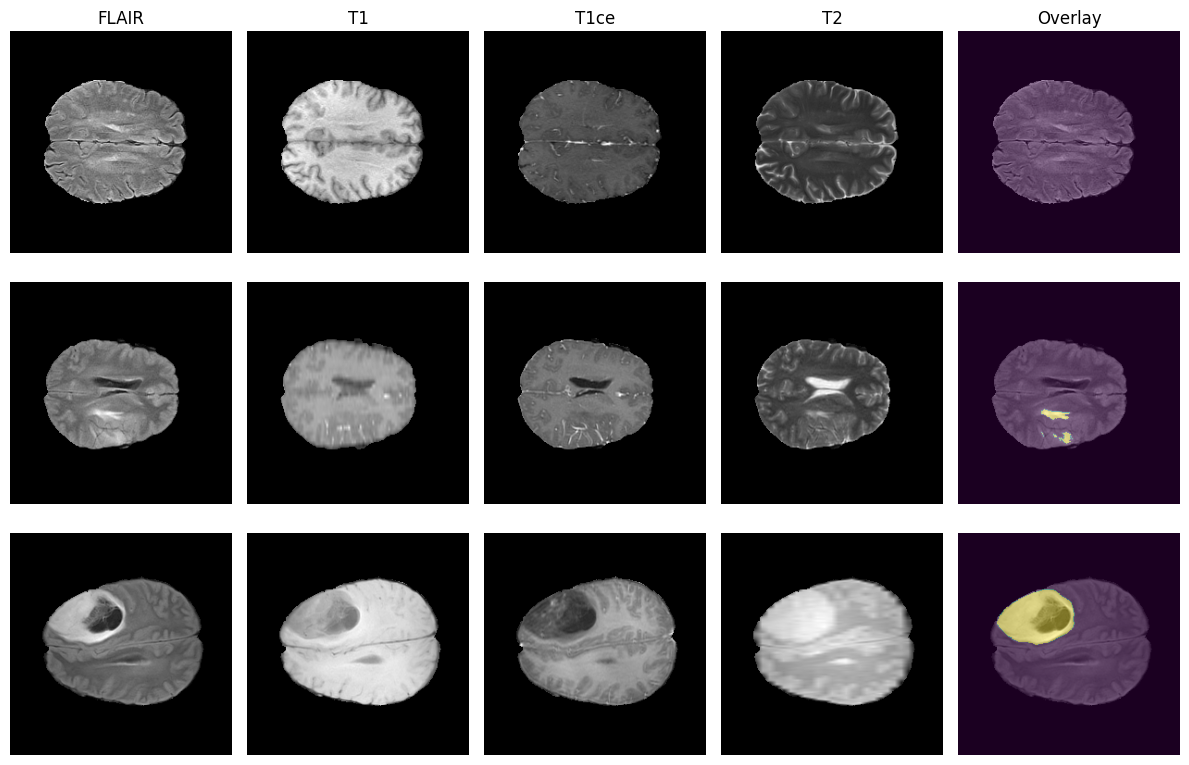

In [3]:
root = '/kaggle/input/train-data'
all_ids = sorted(os.listdir(root))
batch_size = 8

# Split patients
train_ids, val_ids = train_test_split(all_ids, test_size=0.2, random_state=42)
slice_map = None

# Datasets
train_dataset = BraTSSliceDataset(root, train_ids, slice_indices=slice_map or {}, augment=True)
val_dataset   = BraTSSliceDataset(root, val_ids,   slice_indices=slice_map or {}, augment=False)

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)

print(f"Train slices: {len(train_dataset)}, Train batches: {len(train_dataloader)}")
print(f"Val   slices: {len(val_dataset)},   Val   batches: {len(val_dataloader)}")

# Plot some samples from the first training batch
batch = next(iter(train_dataloader))
images = batch['image'].numpy()
masks  = batch['mask'].numpy() 

fig, axes = plt.subplots(3, 5, figsize=(12, 8))

col_titles = ['FLAIR', 'T1', 'T1ce', 'T2', 'Overlay']
for ax, title in zip(axes[0], col_titles):
    ax.set_title(title, fontsize=12)

for i in range(3):
    for m in range(4): 
        ax = axes[i, m]
        ax.imshow(images[i, m], cmap='gray')
        ax.axis('off')
    ax = axes[i, 4]
    ax.imshow(images[i, 0], cmap='gray')
    ax.imshow(masks[i], cmap='viridis', alpha=0.4)
    ax.axis('off')

plt.tight_layout()
plt.show()


Let's construct a U-Net model for the dataset.

# **U-Net**

## **Model**

In [4]:
def double_convolution(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels,  out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):
    def __init__(self, in_channels: int = 4, num_classes: int = 1):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contracting path
        self.down_conv1 = double_convolution(in_channels, 64)
        self.down_conv2 = double_convolution(64,            128)
        self.down_conv3 = double_convolution(128,           256)
        self.down_conv4 = double_convolution(256,           512)
        self.bottom      = double_convolution(512,           1024)

        # Expanding path
        self.up_transpose1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1      = double_convolution(1024, 512)

        self.up_transpose2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2      = double_convolution(512, 256)

        self.up_transpose3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3      = double_convolution(256, 128)

        self.up_transpose4 = nn.ConvTranspose2d(128, 64,  kernel_size=2, stride=2)
        self.up_conv4      = double_convolution(128, 64)

        # Final 1×1 conv maps to the desired number of classes
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down_conv1(x)       
        p1 = self.max_pool2d(x1)    

        x2 = self.down_conv2(p1)   
        p2 = self.max_pool2d(x2)    

        x3 = self.down_conv3(p2)      
        p3 = self.max_pool2d(x3)      

        x4 = self.down_conv4(p3)      
        p4 = self.max_pool2d(x4)      

        x5 = self.bottom(p4)  

        # Decoder
        u1 = self.up_transpose1(x5)         
        c1 = torch.cat([u1, x4], dim=1)     
        x6 = self.up_conv1(c1)           

        u2 = self.up_transpose2(x6)        
        c2 = torch.cat([u2, x3], dim=1)     
        x7 = self.up_conv2(c2)             

        u3 = self.up_transpose3(x7)         
        c3 = torch.cat([u3, x2], dim=1)   
        x8 = self.up_conv3(c3)            

        u4 = self.up_transpose4(x8)       
        c4 = torch.cat([u4, x1], dim=1)    
        x9 = self.up_conv4(c4)              

        return self.out(x9)                


In [5]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        probs = torch.sigmoid(inputs)
        probs_flat   = probs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (probs_flat * targets_flat).sum()
        total        = probs_flat.sum() + targets_flat.sum()

        dice_coeff   = (2. * intersection + smooth) / (total + smooth)

        return 1 - dice_coeff


class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(weight=weight,
                                             reduction='mean' if size_average else 'sum')

    def forward(self, inputs, targets, smooth=1):

        bce = self.bce_loss(inputs, targets)
        probs        = torch.sigmoid(inputs)
        probs_flat   = probs.view(-1)
        targets_flat = targets.view(-1)
        intersection = (probs_flat * targets_flat).sum()
        total        = probs_flat.sum() + targets_flat.sum()
        dice_coeff   = (2. * intersection + smooth) / (total + smooth)
        dice_loss    = 1 - dice_coeff

        return bce + dice_loss


## **Training Process**

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20
lr = 1e-4

criteria = {
    'BCE':      nn.BCEWithLogitsLoss(),
    'Dice':     DiceLoss(),
    'BCE+Dice': DiceBCELoss()
}

experiment_losses = {
    name: {'train': [], 'val': []}
    for name in criteria
}

checkpoints_dir = 'checkpoints'
os.makedirs(checkpoints_dir, exist_ok=True)

for name, criterion in criteria.items():
    print(f"\n=== Training with {name} loss ===")
    model = UNet(in_channels=4, num_classes=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val = float('inf')
    train_hist = experiment_losses[name]['train']
    val_hist   = experiment_losses[name]['val']

    for epoch in range(1, epochs + 1):
        # ——— Training ———
        model.train()
        running_train = 0.0
        for batch in tqdm(train_dataloader, leave=False, desc=f"Train Epoch {epoch}"):
            images = batch['image'].to(device, dtype=torch.float32)  
            masks  = batch['mask'].to(device, dtype=torch.float32) 
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)                        

            optimizer.zero_grad()
            outputs = model(images)                              
            loss    = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_train += loss.item()

        avg_train = running_train / len(train_dataloader)
        train_hist.append(avg_train)

        # ——— Validation ———
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for batch in tqdm(val_dataloader, leave=False, desc=f"Val Epoch {epoch}"):
                images = batch['image'].to(device, dtype=torch.float32)
                masks  = batch['mask'].to(device, dtype=torch.float32)
                if masks.ndim == 3:
                    masks = masks.unsqueeze(1)

                outputs = model(images)
                loss    = criterion(outputs, masks)
                running_val += loss.item()

        avg_val = running_val / len(val_dataloader)
        val_hist.append(avg_val)

        print(f"{name} | Epoch {epoch:2d}/{epochs} → Train: {avg_train:.4f} | Val: {avg_val:.4f}")

        # ——— Checkpoint best model ———
        if avg_val < best_val:
            best_val = avg_val
            ckpt_path = os.path.join(checkpoints_dir, f"unet_{name}_best.pth")
            torch.save(model.state_dict(), ckpt_path)
            print(f"  ↳ Saved best model to {ckpt_path}")


=== Training with BCE loss ===


Train Epoch 1:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 1:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch  1/20 → Train: 0.4513 | Val: 0.1259
  ↳ Saved best model to checkpoints/unet_BCE_best.pth


Train Epoch 2:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 2:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch  2/20 → Train: 0.0815 | Val: 0.0629
  ↳ Saved best model to checkpoints/unet_BCE_best.pth


Train Epoch 3:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 3:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch  3/20 → Train: 0.0530 | Val: 0.0480
  ↳ Saved best model to checkpoints/unet_BCE_best.pth


Train Epoch 4:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 4:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch  4/20 → Train: 0.0478 | Val: 0.0459
  ↳ Saved best model to checkpoints/unet_BCE_best.pth


Train Epoch 5:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 5:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch  5/20 → Train: 0.0406 | Val: 0.0294
  ↳ Saved best model to checkpoints/unet_BCE_best.pth


Train Epoch 6:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 6:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch  6/20 → Train: 0.0330 | Val: 0.0437


Train Epoch 7:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 7:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch  7/20 → Train: 0.0320 | Val: 0.0346


Train Epoch 8:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 8:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch  8/20 → Train: 0.0273 | Val: 0.0351


Train Epoch 9:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 9:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch  9/20 → Train: 0.0279 | Val: 0.0312


Train Epoch 10:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 10:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch 10/20 → Train: 0.0253 | Val: 0.0227
  ↳ Saved best model to checkpoints/unet_BCE_best.pth


Train Epoch 11:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 11:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch 11/20 → Train: 0.0262 | Val: 0.0235


Train Epoch 12:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 12:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch 12/20 → Train: 0.0325 | Val: 0.0231


Train Epoch 13:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 13:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch 13/20 → Train: 0.0254 | Val: 0.0235


Train Epoch 14:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 14:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch 14/20 → Train: 0.0245 | Val: 0.0234


Train Epoch 15:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 15:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch 15/20 → Train: 0.0216 | Val: 0.0233


Train Epoch 16:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 16:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch 16/20 → Train: 0.0220 | Val: 0.0224
  ↳ Saved best model to checkpoints/unet_BCE_best.pth


Train Epoch 17:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 17:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch 17/20 → Train: 0.0230 | Val: 0.0270


Train Epoch 18:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 18:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch 18/20 → Train: 0.0218 | Val: 0.0217
  ↳ Saved best model to checkpoints/unet_BCE_best.pth


Train Epoch 19:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 19:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch 19/20 → Train: 0.0223 | Val: 0.0274


Train Epoch 20:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 20:   0%|          | 0/9 [00:00<?, ?it/s]

BCE | Epoch 20/20 → Train: 0.0212 | Val: 0.0255

=== Training with Dice loss ===


Train Epoch 1:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 1:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch  1/20 → Train: 0.9362 | Val: 0.8857
  ↳ Saved best model to checkpoints/unet_Dice_best.pth


Train Epoch 2:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 2:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch  2/20 → Train: 0.7130 | Val: 0.2946
  ↳ Saved best model to checkpoints/unet_Dice_best.pth


Train Epoch 3:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 3:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch  3/20 → Train: 0.2789 | Val: 0.2343
  ↳ Saved best model to checkpoints/unet_Dice_best.pth


Train Epoch 4:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 4:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch  4/20 → Train: 0.2428 | Val: 0.2172
  ↳ Saved best model to checkpoints/unet_Dice_best.pth


Train Epoch 5:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 5:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch  5/20 → Train: 0.2149 | Val: 0.1805
  ↳ Saved best model to checkpoints/unet_Dice_best.pth


Train Epoch 6:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 6:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch  6/20 → Train: 0.2191 | Val: 0.1770
  ↳ Saved best model to checkpoints/unet_Dice_best.pth


Train Epoch 7:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 7:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch  7/20 → Train: 0.2024 | Val: 0.2416


Train Epoch 8:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 8:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch  8/20 → Train: 0.2116 | Val: 0.1619
  ↳ Saved best model to checkpoints/unet_Dice_best.pth


Train Epoch 9:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 9:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch  9/20 → Train: 0.2014 | Val: 0.1773


Train Epoch 10:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 10:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch 10/20 → Train: 0.1935 | Val: 0.1667


Train Epoch 11:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 11:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch 11/20 → Train: 0.1762 | Val: 0.2295


Train Epoch 12:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 12:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch 12/20 → Train: 0.1963 | Val: 0.1518
  ↳ Saved best model to checkpoints/unet_Dice_best.pth


Train Epoch 13:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 13:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch 13/20 → Train: 0.2027 | Val: 0.1489
  ↳ Saved best model to checkpoints/unet_Dice_best.pth


Train Epoch 14:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 14:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch 14/20 → Train: 0.1978 | Val: 0.1500


Train Epoch 15:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 15:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch 15/20 → Train: 0.2040 | Val: 0.1872


Train Epoch 16:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 16:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch 16/20 → Train: 0.1902 | Val: 0.1581


Train Epoch 17:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 17:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch 17/20 → Train: 0.2125 | Val: 0.1766


Train Epoch 18:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 18:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch 18/20 → Train: 0.1887 | Val: 0.1462
  ↳ Saved best model to checkpoints/unet_Dice_best.pth


Train Epoch 19:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 19:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch 19/20 → Train: 0.1696 | Val: 0.1544


Train Epoch 20:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 20:   0%|          | 0/9 [00:00<?, ?it/s]

Dice | Epoch 20/20 → Train: 0.1687 | Val: 0.1464

=== Training with BCE+Dice loss ===


Train Epoch 1:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 1:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch  1/20 → Train: 1.4082 | Val: 0.9777
  ↳ Saved best model to checkpoints/unet_BCE+Dice_best.pth


Train Epoch 2:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 2:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch  2/20 → Train: 0.7661 | Val: 0.5938
  ↳ Saved best model to checkpoints/unet_BCE+Dice_best.pth


Train Epoch 3:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 3:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch  3/20 → Train: 0.4916 | Val: 0.3565
  ↳ Saved best model to checkpoints/unet_BCE+Dice_best.pth


Train Epoch 4:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 4:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch  4/20 → Train: 0.3381 | Val: 0.3617


Train Epoch 5:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 5:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch  5/20 → Train: 0.2877 | Val: 0.2186
  ↳ Saved best model to checkpoints/unet_BCE+Dice_best.pth


Train Epoch 6:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 6:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch  6/20 → Train: 0.2608 | Val: 0.2177
  ↳ Saved best model to checkpoints/unet_BCE+Dice_best.pth


Train Epoch 7:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 7:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch  7/20 → Train: 0.2397 | Val: 0.1905
  ↳ Saved best model to checkpoints/unet_BCE+Dice_best.pth


Train Epoch 8:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 8:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch  8/20 → Train: 0.2291 | Val: 0.2111


Train Epoch 9:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 9:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch  9/20 → Train: 0.2156 | Val: 0.2123


Train Epoch 10:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 10:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch 10/20 → Train: 0.2142 | Val: 0.2045


Train Epoch 11:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 11:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch 11/20 → Train: 0.2284 | Val: 0.3645


Train Epoch 12:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 12:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch 12/20 → Train: 0.2299 | Val: 0.1839
  ↳ Saved best model to checkpoints/unet_BCE+Dice_best.pth


Train Epoch 13:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 13:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch 13/20 → Train: 0.2189 | Val: 0.2575


Train Epoch 14:   0%|          | 0/36 [00:00<?, ?it/s]

Val Epoch 14:   0%|          | 0/9 [00:00<?, ?it/s]

BCE+Dice | Epoch 14/20 → Train: 0.2247 | Val: 0.1815
  ↳ Saved best model to checkpoints/unet_BCE+Dice_best.pth


Train Epoch 15:   0%|          | 0/36 [00:00<?, ?it/s]

BCE+Dice | Epoch 20/20 → Train: 0.1873 | Val: 0.1622


## **Training Curves**

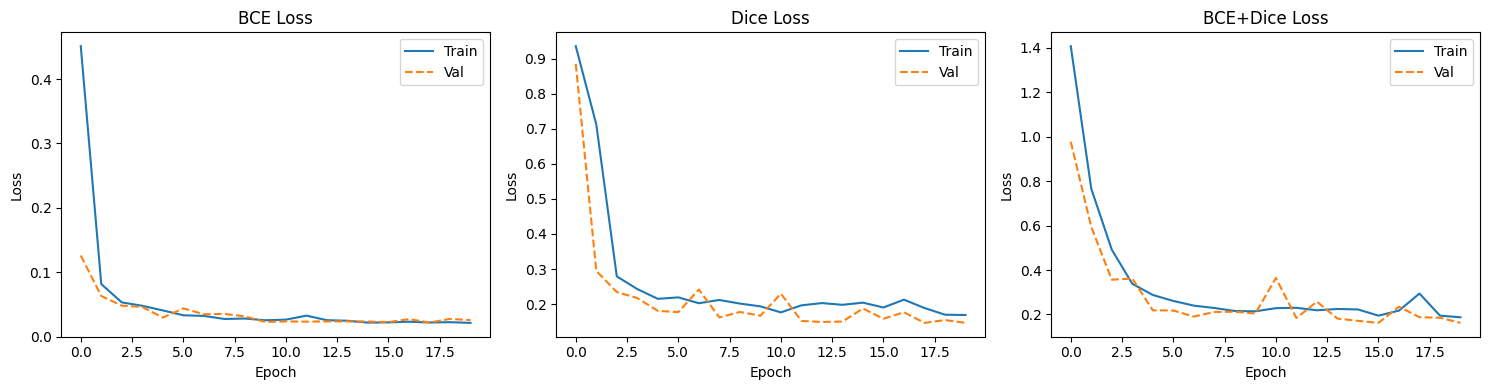

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, history) in zip(axes, experiment_losses.items()):
    # plot train & val
    ax.plot(history['train'], label='Train')
    ax.plot(history['val'],   label='Val', linestyle='--')
    ax.set_title(f'{name} Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()


## **Sample Results**

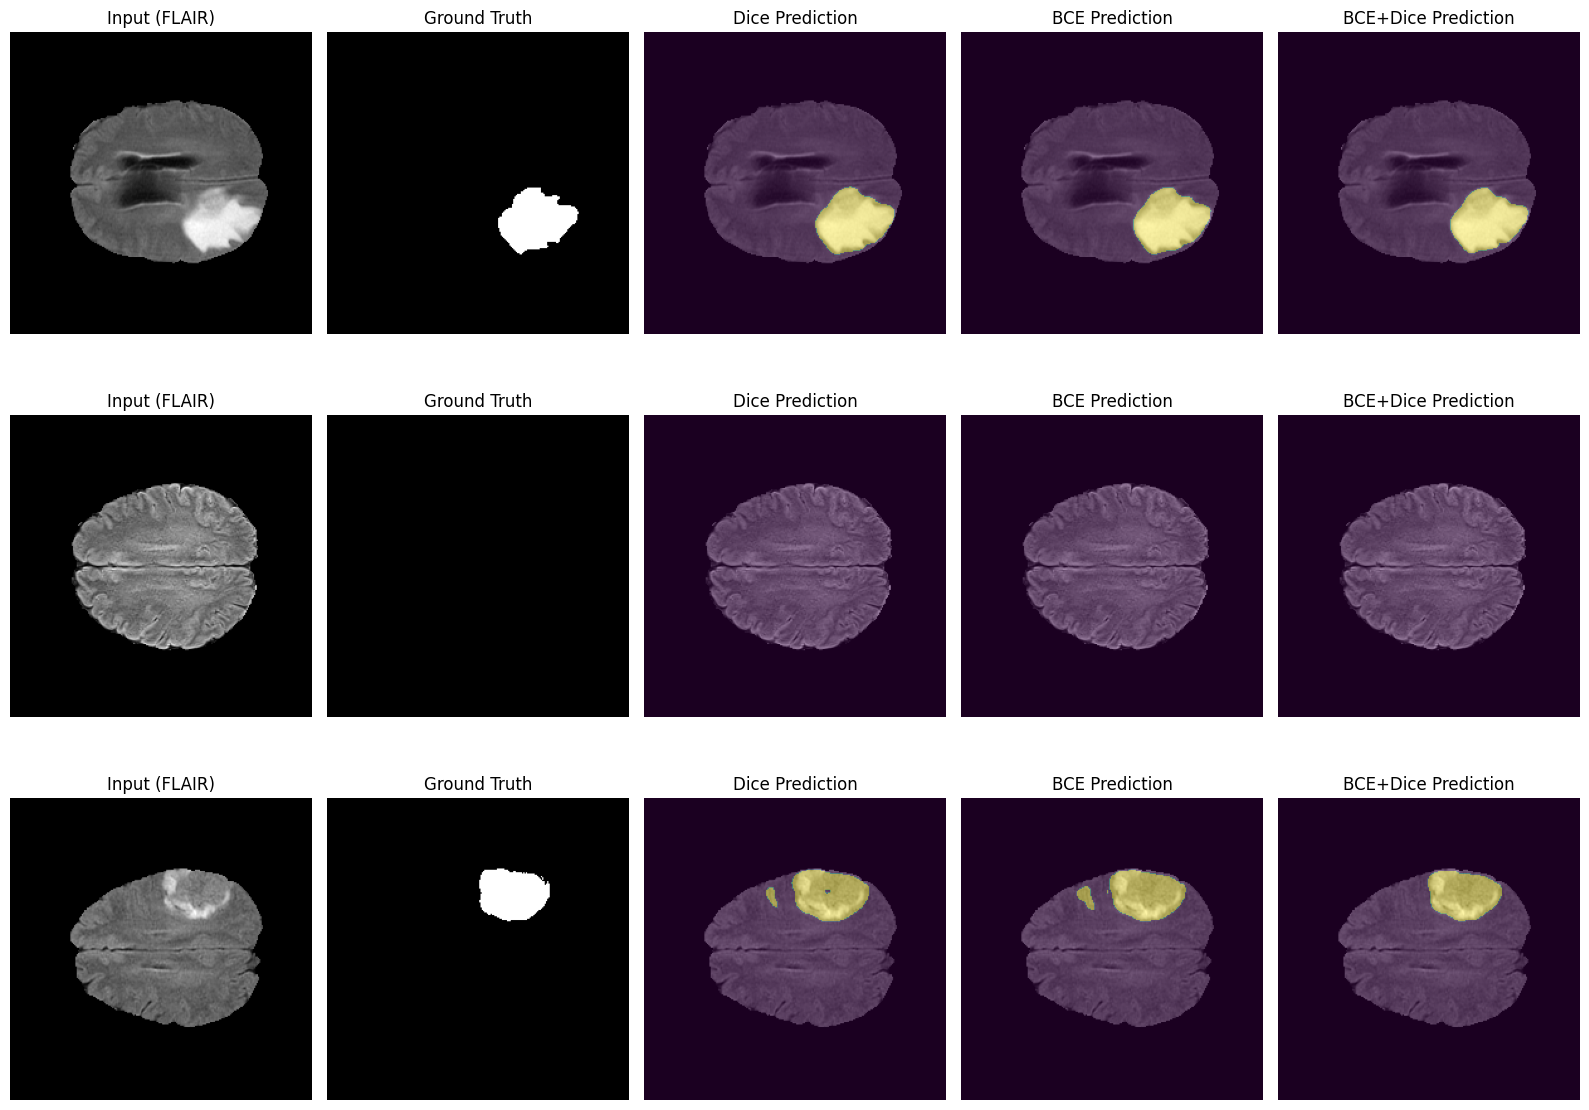

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get a batch
batch = next(iter(val_dataloader))
X = batch['image'].to(device, dtype=torch.float32)      
y = batch['mask'].to(device, dtype=torch.float32)      
if y.ndim == 3:
    y = y.unsqueeze(1)                              

num_samples_to_show = 3
loss_names = ['Dice', 'BCE', 'BCE+Dice']
preds = {}

# Get predictions from each model
for name in loss_names:
    model = UNet(in_channels=4, num_classes=1).to(device)
    ckpt = torch.load(f'checkpoints/unet_{name}_best.pth', map_location=device)
    model.load_state_dict(ckpt)
    model.eval()
    with torch.no_grad():
        logits = model(X)
        pred_mask = (torch.sigmoid(logits) > 0.5).float().cpu()  # [B,1,H,W]
    preds[name] = pred_mask

fig, axes = plt.subplots(num_samples_to_show, 5, figsize=(16, 4 * num_samples_to_show))

for i in range(num_samples_to_show):
    flair = X[i, 0].cpu().numpy()
    gt_mask = y[i, 0].cpu().numpy()

    row_axes = axes[i] if num_samples_to_show > 1 else axes

    # Column 0: Input (FLAIR)
    row_axes[0].imshow(flair, cmap='gray')
    row_axes[0].set_title("Input (FLAIR)")
    row_axes[0].axis('off')

    # Column 1: Ground Truth
    row_axes[1].imshow(gt_mask, cmap='gray')
    row_axes[1].set_title("Ground Truth")
    row_axes[1].axis('off')

    # Columns 2–4: Predictions from Dice, BCE, BCE+Dice
    for j, name in enumerate(loss_names):
        pred = preds[name][i, 0].numpy()
        row_axes[j+2].imshow(flair, cmap='gray')
        row_axes[j+2].imshow(pred, cmap='viridis', alpha=0.4)
        row_axes[j+2].set_title(f"{name} Prediction")
        row_axes[j+2].axis('off')

plt.tight_layout()
plt.show()


## **Evaluation**

In [14]:
# Metric functions
def dice_coef(pred, target, smooth=1e-6):
    p = pred.view(-1)
    t = target.view(-1)
    inter = (p * t).sum().item()
    return (2*inter + smooth) / (p.sum().item() + t.sum().item() + smooth)

def accuracy(pred, target):
    correct = (pred == target).float().sum().item()
    total   = target.numel()
    return correct / total

# Evaluate each checkpoint on val_dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_names = ['BCE', 'Dice', 'BCE+Dice']
results = {}

for name in loss_names:
    # Load best‐validation model
    model = UNet(in_channels=4, num_classes=1).to(device)
    ckpt_path = f'checkpoints/unet_{name}_best.pth'
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    dice_scores = []
    acc_scores  = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Evaluating {name}"):
            imgs = batch['image'].to(device, dtype=torch.float32)  
            masks = batch['mask'].to(device, dtype=torch.float32)  
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)                          

            logits = model(imgs)                                  
            probs  = torch.sigmoid(logits)
            preds  = (probs > 0.5).float()

            dice_scores.append(dice_coef(preds, masks))
            acc_scores.append(accuracy(preds, masks))

    results[name] = {
        'mean_dice': np.mean(dice_scores),
        'mean_acc':  np.mean(acc_scores)
    }

for name, mets in results.items():
    print(f"{name:8s} → Mean Dice: {mets['mean_dice']:.4f}, Mean Acc: {mets['mean_acc']:.4f}")

best_loss = max(results.items(), key=lambda x: x[1]['mean_dice'])[0]
print(f"\nBest loss by mean Dice: {best_loss}")


Evaluating BCE:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Dice:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating BCE+Dice:   0%|          | 0/9 [00:00<?, ?it/s]

BCE      → Mean Dice: 0.8398, Mean Acc: 0.9911
Dice     → Mean Dice: 0.8550, Mean Acc: 0.9922
BCE+Dice → Mean Dice: 0.8745, Mean Acc: 0.9935

Best loss by mean Dice: BCE+Dice


Overall, the combined **BCE + Dice** loss gives you the best quantitative performance:

| Loss         | Mean Dice  | Mean Acc   |
| ------------ | ---------- | ---------- |
| BCE          | 0.8398     | 0.9911     |
| Dice         | 0.8550    | 0.9922     |
| **BCE+Dice** | **0.8745** | **0.9935** |

A few observations:

1. **Dice vs BCE alone**

   * Dice‐only and BCE‐only are nearly tied, but each has its quirks:

     * BCE tends to spread probability mass more diffusely (you may see over‑smooth or under‑segmented edges).
     * Dice‐only can sometimes miss low‐confidence “fingers” of the tumor (since it optimizes global overlap).

2. **Why BCE + Dice works best**

   * The cross‑entropy term encourages correct classification at every pixel, while the Dice term forces high global overlap.
   * Together they balance pixel‑wise fidelity with region‑level consistency, giving you that extra \~1 % gain in Dice.

3. **Accuracy isn’t telling the full story**

   * With heavy class imbalance (tumor vs background), even a model that labels everything background can score > 99 % accuracy.
   * Dice is a more meaningful metric here, since it directly measures how well your predicted mask overlaps the true lesion.

4. **Qualitative sample look**

   * All three capture the rough tumor location, but comparing the overlays:

     * **BCE** can leave the edges a bit “blobby.”
     * **Dice** sometimes shrinks the lesion slightly.
     * **BCE+Dice** most closely matches the ground‑truth boundary in both shape and extent.

---


Now we augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules, etc. We describe the expected architecture for this notebook:

+ *ResNet:* As a base sub-module, we define each ResNet block as two consecutive convolutional layers with a GELU activation in between and Group Normalization after each convolutional layer. You can use this module in Down/Up blocks. Also, by removing the residual connection, you can use this block as a convolutional network throughout the network.
+ *Attention:* This is also a sub-module consisting of a Layer Normalization, Multi-head Attention (use from `torch.nn`), a residual connection, a feed-forward network, and another residual connection.

You can implement the following structure for UNet:

+ Convolutional block
+ Down block
+ Attention
+ Down block
+ Attention
+ Down block
+ Attention

+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)

+ Up block
+ Attention
+ Up block
+ Attention
+ Up block
+ Attention
+ Convolutional block

# **Attention U-Net**

## **Model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [15]:
class ConvResNet(nn.Module):
    """
    A small ‘ResNet’‐style block:
    Conv → GroupNorm → GELU → Conv → GroupNorm, with a residual connection.
    """
    def __init__(self, in_ch, out_ch, groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.gn1   = nn.GroupNorm(groups, out_ch)
        self.act   = nn.GELU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.gn2   = nn.GroupNorm(groups, out_ch)
        if in_ch != out_ch:
            self.res_conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        else:
            self.res_conv = None

    def forward(self, x):
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.gn2(out)
        res = x if self.res_conv is None else self.res_conv(x)
        return out + res


class Down(nn.Module):
    """
    Downsampling block: ConvResNet → MaxPool2d
    Returns: (pooled, skip_connection)
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.resblock = ConvResNet(in_ch, out_ch)
        self.pool     = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x, t=None):
        x = self.resblock(x)
        return self.pool(x), x


class Up(nn.Module):
    """
    Upsampling block: ConvTranspose2d → pad/crop → concat skip → ConvResNet
    """
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        # upsample in_ch → out_ch
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        # process concatenated [skip_ch + out_ch] → out_ch
        self.resblock = ConvResNet(skip_ch + out_ch, out_ch)

    def forward(self, x, skip, t=None):
        x = self.up(x)
        # pad if needed
        diffY = skip.size(2) - x.size(2)
        diffX = skip.size(3) - x.size(3)
        if diffY or diffX:
            x = F.pad(x, [
                diffX // 2, diffX - diffX // 2,
                diffY // 2, diffY - diffY // 2
            ])
        x = torch.cat([skip, x], dim=1)
        return self.resblock(x)


class Attention(nn.Module):
    """
    Bottleneck self‐attention:
    LayerNorm → MultiheadAttention → residual → LayerNorm → FFN → residual
    """
    def __init__(self, dim, num_heads=4, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        hidden = int(dim * mlp_ratio)
        self.ffn   = nn.Sequential(
            nn.Linear(dim, hidden), nn.GELU(),
            nn.Linear(hidden, dim)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        flat = x.flatten(2).permute(0, 2, 1)       
        y = self.norm1(flat)
        attn_out, _ = self.attn(y, y, y)
        x2 = attn_out + flat
        y2 = self.norm2(x2)
        ffn_out = self.ffn(y2) + x2
        return ffn_out.permute(0, 2, 1).reshape(B, C, H, W)


class UNet_Attention(nn.Module):
    """
    UNet with a single self‐attention block in the bottleneck to avoid OOM.
    """
    def __init__(self, in_channels=4, base_ch=64, num_classes=1):
        super().__init__()
        # Encoder
        self.conv0 = ConvResNet(in_channels, base_ch)
        self.down1 = Down(base_ch,      base_ch * 2)
        self.down2 = Down(base_ch * 2,  base_ch * 4)
        self.down3 = Down(base_ch * 4,  base_ch * 8)
        self.down4 = Down(base_ch * 8,  base_ch * 16)

        # Bottleneck with attention
        self.bot1 = ConvResNet(base_ch * 16, base_ch * 16)
        self.attn = Attention(base_ch * 16, num_heads=4)
        self.bot2 = ConvResNet(base_ch * 16, base_ch * 8)

        # Decoder
        self.up1 = Up(base_ch * 8,  base_ch * 16, base_ch * 8)
        self.up2 = Up(base_ch * 8,  base_ch * 8,  base_ch * 4)
        self.up3 = Up(base_ch * 4,  base_ch * 4,  base_ch * 2)
        self.up4 = Up(base_ch * 2,  base_ch * 2,  base_ch)

        # Final 1×1 conv
        self.out = nn.Conv2d(base_ch, num_classes, kernel_size=1)

    def forward(self, x, t=None):
        # Encoder
        x0 = self.conv0(x)
        d1, s1 = self.down1(x0)
        d2, s2 = self.down2(d1)
        d3, s3 = self.down3(d2)
        d4, s4 = self.down4(d3)

        # Bottleneck
        b = self.bot1(d4)
        b = self.attn(b)
        b = self.bot2(b)

        # Decoder
        u1 = self.up1(b,  s4)
        u2 = self.up2(u1, s3)
        u3 = self.up3(u2, s2)
        u4 = self.up4(u3, s1)

        return self.out(u4)

## **Training Process**

In [16]:
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs    = 20
lr        = 1e-4
criterion = DiceBCELoss()

# prepare checkpoint folder
ckpt_dir = 'checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)

train_losses, val_losses = [], []
best_val = float('inf')
model = UNet_Attention(in_channels=4, base_ch=64, num_classes=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs+1):
    # — Training —
    model.train()
    running_train = 0.0
    for batch in tqdm(train_dataloader, leave=False, desc=f"Train Ep{epoch}"):
        imgs = batch['image'].to(device, dtype=torch.float32)
        masks= batch['mask'].to(device, dtype=torch.float32)
        if masks.ndim==3: masks = masks.unsqueeze(1)

        optimizer.zero_grad()
        preds = model(imgs)
        loss  = criterion(preds, masks)
        loss.backward()
        optimizer.step()
        running_train += loss.item()
    avg_train = running_train / len(train_dataloader)
    train_losses.append(avg_train)

    # — Validation —
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, leave=False, desc=f"Val Ep{epoch}"):
            imgs = batch['image'].to(device, dtype=torch.float32)
            masks= batch['mask'].to(device, dtype=torch.float32)
            if masks.ndim==3: masks = masks.unsqueeze(1)
            preds = model(imgs)
            running_val += criterion(preds, masks).item()
    avg_val = running_val / len(val_dataloader)
    val_losses.append(avg_val)

    print(f"[AttUNet] Epoch {epoch}/{epochs} → Train: {avg_train:.4f}, Val: {avg_val:.4f}")

    # — Checkpoint best —
    if avg_val < best_val:
        best_val = avg_val
        path = os.path.join(ckpt_dir, 'unet_attention_best.pth')
        torch.save(model.state_dict(), path)
        print(f"  ↳ Saved new best Attention‑UNet to {path}")


Train Ep1:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep1:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 1/20 → Train: 0.5182, Val: 0.2258
  ↳ Saved new best Attention‑UNet to checkpoints/unet_attention_best.pth


Train Ep2:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep2:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 2/20 → Train: 0.2710, Val: 0.2000
  ↳ Saved new best Attention‑UNet to checkpoints/unet_attention_best.pth


Train Ep3:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep3:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 3/20 → Train: 0.2449, Val: 0.2542


Train Ep4:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep4:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 4/20 → Train: 0.2077, Val: 0.1558
  ↳ Saved new best Attention‑UNet to checkpoints/unet_attention_best.pth


Train Ep5:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep5:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 5/20 → Train: 0.1774, Val: 0.1746


Train Ep6:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep6:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 6/20 → Train: 0.1830, Val: 0.1934


Train Ep7:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep7:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 7/20 → Train: 0.1819, Val: 0.1656


Train Ep8:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep8:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 8/20 → Train: 0.1622, Val: 0.1749


Train Ep9:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep9:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 9/20 → Train: 0.1681, Val: 0.2535


Train Ep10:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep10:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 10/20 → Train: 0.1732, Val: 0.1726


Train Ep11:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep11:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 11/20 → Train: 0.1543, Val: 0.1447
  ↳ Saved new best Attention‑UNet to checkpoints/unet_attention_best.pth


Train Ep12:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep12:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 12/20 → Train: 0.1632, Val: 0.1529


Train Ep13:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep13:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 13/20 → Train: 0.1603, Val: 0.1435
  ↳ Saved new best Attention‑UNet to checkpoints/unet_attention_best.pth


Train Ep14:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep14:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 14/20 → Train: 0.1584, Val: 0.1893


Train Ep15:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep15:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 15/20 → Train: 0.1799, Val: 0.1256
  ↳ Saved new best Attention‑UNet to checkpoints/unet_attention_best.pth


Train Ep16:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep16:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 16/20 → Train: 0.1316, Val: 0.1264


Train Ep17:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep17:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 17/20 → Train: 0.1326, Val: 0.1315


Train Ep18:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep18:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 18/20 → Train: 0.1451, Val: 0.1193
  ↳ Saved new best Attention‑UNet to checkpoints/unet_attention_best.pth


Train Ep19:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep19:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 19/20 → Train: 0.1256, Val: 0.1295


Train Ep20:   0%|          | 0/36 [00:00<?, ?it/s]

Val Ep20:   0%|          | 0/9 [00:00<?, ?it/s]

[AttUNet] Epoch 20/20 → Train: 0.1308, Val: 0.1409


## **Training Curves**

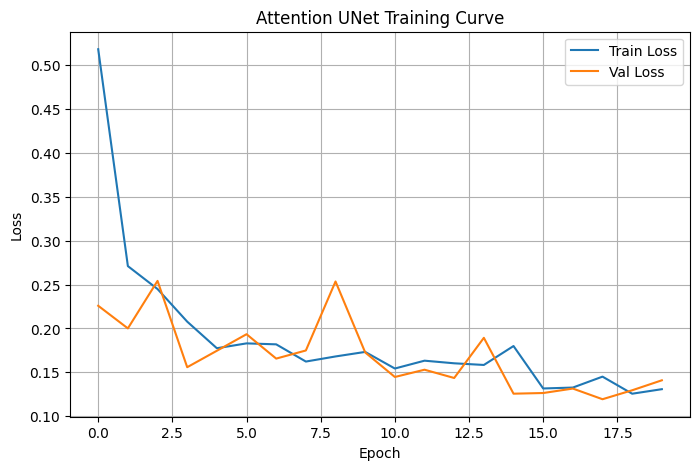

In [17]:
# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Attention UNet Training Curve')
plt.legend()
plt.grid(True)
plt.show()


## **Sample Results**

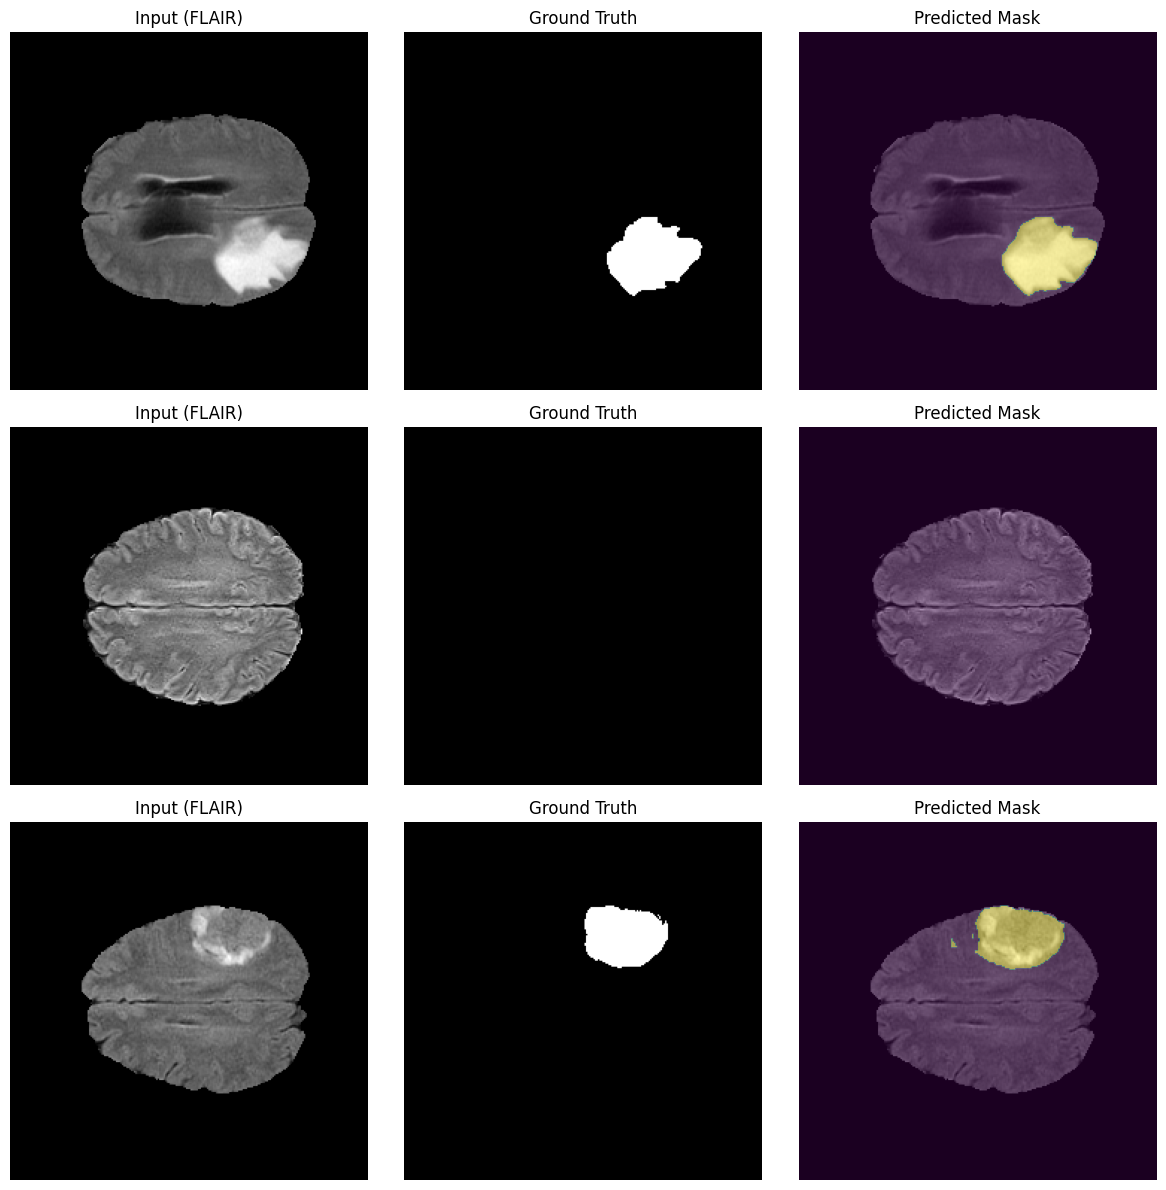

In [18]:
batch = next(iter(val_dataloader))
X = batch['image'].to(device, dtype=torch.float32)
y = batch['mask'].to(device, dtype=torch.float32)
if y.ndim == 3:
    y = y.unsqueeze(1)

model.eval()
with torch.no_grad():
    logits = model(X)
    preds = (torch.sigmoid(logits) > 0.5).float().cpu()  # [B,1,H,W]

num_samples_to_show = 3
fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(12, 4 * num_samples_to_show))

for i in range(num_samples_to_show):
    flair = X[i, 0].cpu().numpy()       
    gt    = y[i, 0].cpu().numpy()
    pred  = preds[i, 0].numpy()

    row_axes = axes[i] if num_samples_to_show > 1 else axes

    row_axes[0].imshow(flair, cmap='gray')
    row_axes[0].set_title("Input (FLAIR)")
    row_axes[0].axis('off')

    row_axes[1].imshow(gt, cmap='gray')
    row_axes[1].set_title("Ground Truth")
    row_axes[1].axis('off')

    row_axes[2].imshow(flair, cmap='gray')
    row_axes[2].imshow(pred, cmap='viridis', alpha=0.4)
    row_axes[2].set_title("Predicted Mask")
    row_axes[2].axis('off')

plt.tight_layout()
plt.show()


## **Evaluation**

In [19]:
# Evaluate Best Model 
def dice_coef(pred, target, smooth=1e-6):
    p = pred.view(-1)
    t = target.view(-1)
    inter = (p * t).sum().item()
    return (2 * inter + smooth) / (p.sum().item() + t.sum().item() + smooth)

def accuracy(pred, target):
    correct = (pred == target).float().sum().item()
    total   = target.numel()
    return correct / total

# Load best Attention UNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet_Attention(in_channels=4, base_ch=64, num_classes=1).to(device)
model.load_state_dict(torch.load('checkpoints/unet_attention_best.pth', map_location=device))
model.eval()

dice_scores = []
acc_scores = []

with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Evaluating Attention UNet"):
        imgs = batch['image'].to(device, dtype=torch.float32)     
        masks = batch['mask'].to(device, dtype=torch.float32)    
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)

        logits = model(imgs)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        dice_scores.append(dice_coef(preds, masks))
        acc_scores.append(accuracy(preds, masks))

mean_dice = np.mean(dice_scores)
mean_acc  = np.mean(acc_scores)

print(f"\n📊 Attention U-Net Evaluation:")
print(f"   Mean Dice: {mean_dice:.4f}")
print(f"   Mean Acc : {mean_acc:.4f}")


Evaluating Attention UNet:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Attention U-Net Evaluation:
   Mean Dice: 0.9075
   Mean Acc : 0.9952


# **U-Net vs. Attention U-Net**

## 1. **Loss Curves**:

* **U-Net (BCE + Dice Loss)**: The loss curve for U-Net shows a rapid initial decrease, followed by a plateau as the model continues training. This is a typical sign of convergence, but the validation loss follows a slightly different trajectory, indicating a potential overfitting issue after a certain number of epochs. The model seems to over-optimize on the training data, and the validation loss doesn't drop as effectively.

* **Attention U-Net**: The loss curve for Attention U-Net is more volatile, especially for the validation set. However, it still shows a steady drop in both training and validation loss over time. The slight fluctuations in the validation loss could indicate that the attention mechanism is focusing too heavily on certain features, which might require more fine-tuning. Still, the model does show a strong ability to generalize based on the validation performance.

## 2. **Segmentation Samples**:

* **U-Net Predictions**: The predicted masks from U-Net show a reasonably good approximation of the ground truth but with certain rough areas and missed segments, especially in the regions of complex structures (e.g., brain lesions). This is evident in the images where the segmentation mask is either incomplete or imprecise, indicating the model's struggle with detecting smaller or less distinct features.

* **Attention U-Net Predictions**: The Attention U-Net performs significantly better in these sample images. The segmentation is cleaner, and the predicted masks are more aligned with the ground truth. The attention mechanism allows the model to focus on finer details of the image, capturing structures that U-Net misses. This is especially visible in areas with complicated structures or lower contrast, where Attention U-Net appears to perform better.

## 3. **Evaluation Metrics**:

* **U-Net (BCE + Dice Loss)**:

  * **Mean Dice**: 0.8745
  * **Mean Accuracy**: 0.9935
  * The performance of U-Net is strong, with a high Dice coefficient (0.8745), which indicates a good overlap between predicted and ground truth masks. However, it lags behind the Attention U-Net in terms of segmentation precision, as the Dice coefficient is lower.
  * The **accuracy (0.9935)** is also high, suggesting that the model correctly identifies most of the image, including background and foreground. This is good, but the slight gap in Dice suggests that U-Net might not always get the segmentation regions right, especially in more complex areas.
* **Attention U-Net**:

  * **Mean Dice**: 0.9075
  * **Mean Accuracy**: 0.9952
  * Attention U-Net outperforms U-Net in both **Dice coefficient (0.9075)** and **accuracy (0.9952)**. The higher Dice score confirms that Attention U-Net is better at accurately segmenting regions of interest and achieving a higher overlap with the ground truth.
  * The **accuracy** of 0.9952 also shows that Attention U-Net is better at distinguishing between foreground and background while being more precise in identifying structures in the images.

## 4. **General Observations**:

* **Attention Mechanism**: The **Attention U-Net** clearly benefits from the attention mechanism, which helps the model focus on important regions within the image. This is particularly valuable in medical image segmentation tasks, where distinguishing small or subtle lesions and structures can be critical. The higher Dice coefficient and better prediction alignment with the ground truth are strong indicators that the attention mechanism improves segmentation accuracy, especially in challenging areas.

* **U-Net Strengths**: Despite the slightly lower performance in comparison, **U-Net** still performs well with high accuracy and reasonable Dice scores. The model is more stable in its performance, with less volatility in its loss curve. However, its inability to capture finer details means it might miss out on smaller features or suffer from less precise segmentations in some cases.

## 5. **Visual Comparison**:

* **U-Net**: The masks generated by U-Net tend to be less detailed, and the edges of the segmented regions may appear less well-defined. There are instances where U-Net misses smaller or more intricate areas, which could impact the model's effectiveness in highly specialized tasks.
* **Attention U-Net**: The predicted masks from Attention U-Net are visibly sharper, with better attention to fine details in the segmentation. These results showcase the effectiveness of the attention mechanism, which likely leads to higher segmentation precision, particularly in complex regions of the image.

---

## **Conclusion**:

* **Attention U-Net** is the clear winner in this comparison, outperforming **U-Net** in all critical aspects:

  * **Better Segmentation Precision**: Attention U-Net achieves a higher Dice coefficient (0.9075 vs. 0.8745), indicating it is more capable of accurately capturing the regions of interest.
  * **Better Focus on Important Areas**: The attention mechanism gives the model an edge in segmenting complex areas that may be difficult for standard U-Net.
  * **Higher Accuracy**: The higher accuracy of 0.9952 for Attention U-Net also indicates that the model is more reliable in both identifying and classifying the foreground and background regions of the image.

While **U-Net** is still a strong model, particularly for simpler tasks or when computational resources are limited, **Attention U-Net** excels in tasks requiring higher segmentation accuracy and fine-grained details, making it more suitable for complex medical imaging tasks or other high-precision applications.

For further improvement, Attention U-Net could benefit from additional regularization techniques or further optimization of the attention mechanism to reduce potential overfitting and the fluctuations in the validation loss.
